In [22]:
# import modules
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.ticker as ticker
import scipy.optimize as opt


os.chdir("/Users/etmu9498/research/code/scripts")
import tc_metadata
import helper_fns
import make_plots_new_heights
import cloud_height

In [2]:
# this function really makes use of the code found in "cloud backscatter to height test.ipynb" to create these figures!

In [5]:
# locally defined helper fn to make power plot!
def plot_power_ch1( data_path, data_file):
    warnings.filterwarnings("ignore")
    # get data
    os.chdir( data_path)
    crl_data = xr.open_dataset( data_file)

    # plot crl data using in situ x axis!
    # choose x axis
    xaxis = crl_data.in_situ_distance
    # plot things
    plt.pcolormesh(  xaxis, - crl_data.H_new, crl_data.power_new.transpose(), vmin = -30, vmax =-10)

    '''
    # this is how to plot crl data using tdr scale! indicese were off by one in 2nd line
    xaxis = crl_data.tdr_distance
    plt.pcolormesh(  xaxis, - crl_data.H_new, crl_data.power_new.transpose()[:, 0:-1], vmin = -30, vmax =-10)
    '''
    
    plt.ylabel( 'Height (km)')    
    cbar = plt.colorbar(label="CRL Return Power ( dBz)", ticks=[-30, -20, -10])
    
    cbar.ax.set_ylabel( ylabel="CRL Return Power ( dBz)")
    cbar.ax.tick_params(labelsize=21)

    
    # plt.grid( 'on')
    plt.ylim( [ 0, crl_data.H_max + .1])

    ax = plt.gca()
    ax.set_facecolor('k')
    warnings.filterwarnings("default")

In [11]:
# simple function to find atmospheric pressure
def find_p(height):
    # taken from https://en.wikipedia.org/wiki/Atmospheric_pressure
    p0 = 1013.25 # surface pressure, hPa
    g = 9.81 # m/s^2
    M = 0.02897 # kg/mol
    T0 = 288.16 # K
    R0 = 8.314462618 # J/(mol·K)

    # find pressure
    p = p0 * np.exp( ( - (g*M*height) / (T0*R0)) )
    return p

# find density from pressure and temperature (assuming dry air)
def find_rho(p, T):
    R_spec = 287.053 # J kg−1 K−1
    rho = (p * 100) / (R_spec * (273.15 + T))
    return rho

# find the molecular backscatter coefficient using pressure (hPa), temperature (C), and crl wavelength (nm)
def find_molec_backscatter(p, T, crl_wavelength):
    # find the number density first
    k = 1.381e-23 # boltzmann constant, m2 kg / s2 K
    Molecular_number_density = (p*100.) / (k * (T+273.15))
    MND = Molecular_number_density* 10**-32 # convert number density to m^(-3)
    Molecular_backscattering_Coefficient = MND *5.45 *(550./ crl_wavelength)**4 # units: m^(-1)sr^(-1)

    return Molecular_backscattering_Coefficient * 10**3 # units: km^(-1)sr^(-1)


In [6]:
# setup: choose the 9/29 eye pass 1 dataset
metadata = tc_metadata.all_data( tc='sam')
crl_path = metadata['um_crl_path']
crl_name = 'crl-sam-09-29-eye-1.nc'
dataset = 5

# load data and helpful values
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)
xaxis_data = crl_data.in_situ_distance.values
dist0 = metadata[ 'in_situ_eyewall_dists'][dataset][ 0] # eyewall limit 0
dist1 = metadata[ 'in_situ_eyewall_dists'][dataset][ 1] # eyewall limit 1

# find the indices and values in the crl distance dataset closest to the eyewall_dists limits
i1, x1 = helper_fns.closest_val( xaxis_data, dist0)
i2, x2 = helper_fns.closest_val( xaxis_data, dist1)

# cloud heights within the specified axes
# ignore counts for here
# find only the uppermost cloud peak
cloud_heights, xaxis = cloud_height.find_cloud_heights( crl_name, -30, i1, i2, xaxis='in-situ-dist', crl_path=crl_path, new_heights=True)
# old way includes multiple cloud heights... maybe do this instead?
# cloud_heights, xaxis, counts = cloud_height.find_cloud_heights( crl_name, -30, i1, i2, crl_path=crl_path, new_heights=True)


# setup for plotting
power = crl_data.power_new[i1:i2].values
dist = crl_data.in_situ_distance[i1:i2].values
profile = 25  # original profile 1 = 35

# adding a complementary plot!
profile2 = 145

# index where chosen distance equals return index... works for rainfall_positions and xaxis!
# xinds = np.where( xaxis == dist[ profile])[0]
# xinds = np.where( xaxis == dist[ profile])[0]

print( xaxis[ profile])
print( cloud_heights[ profile])

<xarray.DataArray 'in_situ_distance' ()>
array(-26.5551)
Coordinates:
    in_situ_distance  float64 -26.56
    H_max             float64 ...
Attributes:
    long_name:    in_situ_distance
    units:        meters
    description:  Distance from the center of the TC, determined from P-3 hei...
1.548590000000042


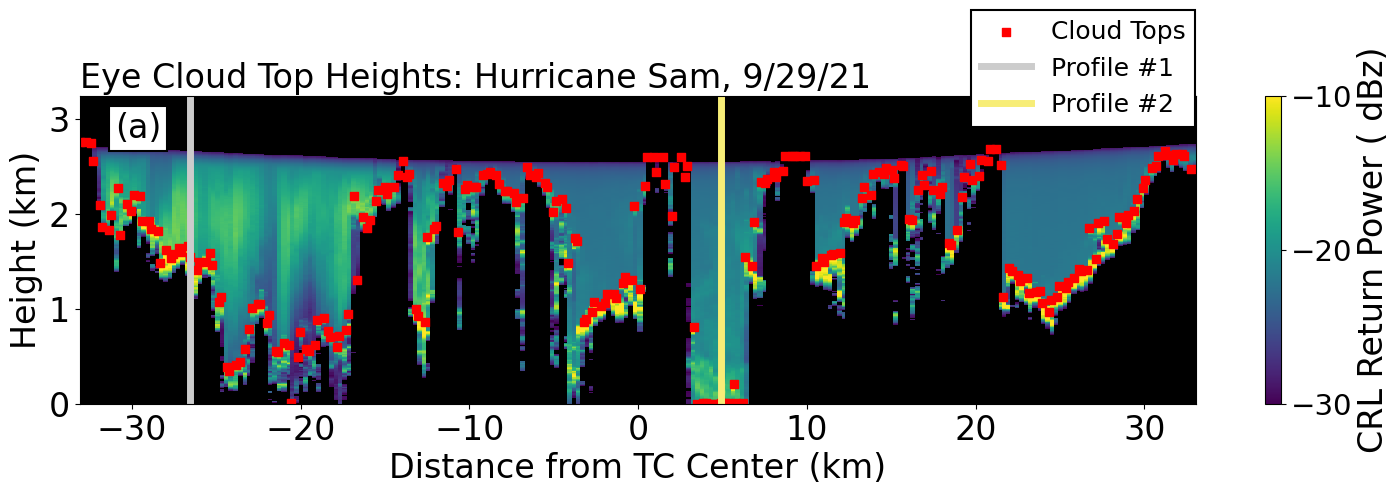

In [7]:
# Make plot 1: cloud heights over crl data!
fs = 24
helper_fns.change_font_sizes(small=fs, medium=fs)

fig = plt.figure( figsize=(18, 4))
xtxt = -31
ytxt = 2.8

plot_power_ch1( crl_path, crl_name)

plt.scatter( xaxis, cloud_heights, c='r', s=30, label='Cloud Tops', marker='s')
# plt.plot( xaxis, cloud_heights, c='r', linewidth=3, label="Cloud Top Heights")

plt.title( "Eye Cloud Top Heights: Hurricane Sam, 9/29/21", loc='left')
plt.xlabel("Distance from TC Center (km)")

plt.xlim( [x1, x2])

plt.axvline( x=crl_data.in_situ_distance[i1:i2][ profile], c='.8', alpha = 1, linewidth=5, label="Profile #1")
plt.axvline( x=crl_data.in_situ_distance[i1:i2][ profile2], c=(0.970, 0.928, 0.466), alpha = 1, linewidth=5, label="Profile #2")

txt = plt.text(xtxt, ytxt, "(a)", fontsize=fs)
txt.set_bbox(dict(facecolor='w', alpha=1.0, edgecolor='k', linewidth=1.5))

# leg = plt.legend( loc='upper right', bbox_to_anchor=(1.01, 1.15), fancybox=False, shadow=False, fontsize=17, facecolor='w', framealpha=1) # 1.3
leg = plt.legend( loc='upper right', bbox_to_anchor=(1.011, 1.32), fancybox=False, shadow=False, fontsize=18, facecolor='w', framealpha=1) # 1.3
leg.get_frame().set_linewidth( 1.5) 
leg.get_frame().set_edgecolor('k')

os.chdir( "/Users/etmu9498/research-private/eye-cloud-paper/")
plt.savefig( "cloud_top_heights.png", bbox_inches='tight', dpi=500 )

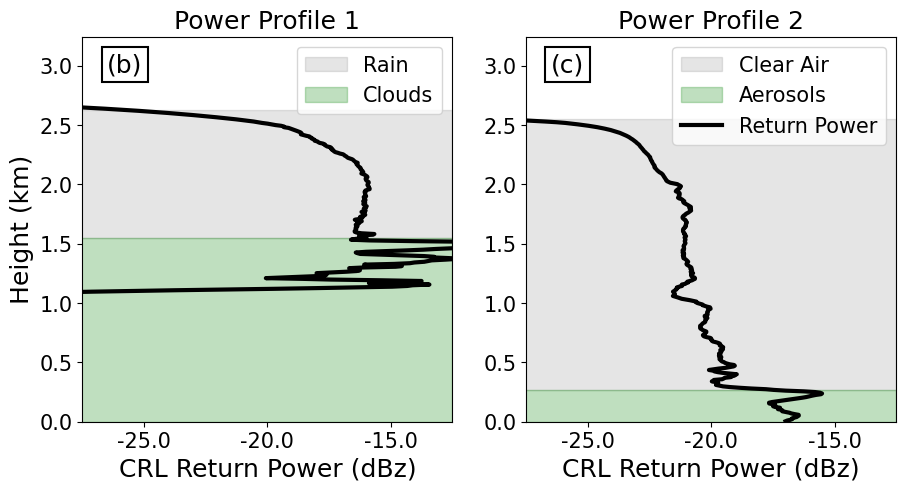

In [8]:
##### plot 2: power vs height cross section for first vertical power profile!

plt.figure( figsize=( 10.5, 5))
helper_fns.change_font_sizes(small=18, medium=18)
labelfont=15
xtxt = -26.5
ytxt = 2.95

crl_path = metadata['um_crl_path']
crl_name = 'crl-sam-09-29-eye-1.nc'
os.chdir(crl_path)
crl_data = xr.open_dataset(crl_name)

plt.subplot(121)
plt.xlabel( "CRL Return Power (dBz)")
plt.ylabel( "Height (km)")
plt.title( "Power Profile 1")

plt.ylim( [ 0, crl_data.H_max + .1])
plt.xlim( [-27.5, -12.5])
height = cloud_heights[ profile]

plt.axhspan(height, 2.63, -15, color='k', alpha=.1, label='Rain')
plt.axhspan(0, height, -15, color='g', alpha=.25, label='Clouds')
plt.plot( power[ profile], - crl_data.H_new, c='k', linewidth=3)

plt.xticks( [-25.00, -20.0, -15.0])
ax= plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.tick_params(axis='both', which='major', labelsize=labelfont)

txt = plt.text(xtxt, ytxt, "(b)", fontsize=18)
txt.set_bbox(dict(facecolor='w', alpha=1.0, edgecolor='k', linewidth=1.5))

plt.legend(loc='upper right', fontsize=labelfont)


crl_path = metadata['um_crl_path']
crl_name = 'crl-sam-09-29-eye-1.nc'
os.chdir(crl_path)
crl_data = xr.open_dataset(crl_name)

plt.subplot(122)
plt.xlabel( "CRL Return Power (dBz)")
plt.title( "Power Profile 2")

plt.ylim( [ 0, crl_data.H_max + .1])
plt.xlim([-27.5, -12.5])
height = cloud_heights[ profile2]

# artifically remove the height from the plot (cloud height of 0.0 km)
# plt.axhline( y=height - 2, c='b', linewidth=2.5, alpha=1, label='Cloud Top Height', linestyle='--')
# plt.plot( power[ profile2], - crl_data.H_new, c='g', linewidth=3, alpha=.5)

plt.axhspan(.27, 2.55, -15, color='k', alpha=.1, label='Clear Air')
plt.axhspan(0, .27, -15, color='g', alpha=.25, label='Aerosols') # 'navajowhite'
plt.plot( power[ profile2], - crl_data.H_new, c='k', linewidth=3, label='Return Power')

plt.xticks( [-25.00, -20.0, -15.0])
ax= plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.tick_params(axis='both', which='major', labelsize=labelfont)

txt = plt.text(xtxt, ytxt, "(c)", fontsize=18)
txt.set_bbox(dict(facecolor='w', alpha=1.0, edgecolor='k', linewidth=1.5))

plt.legend(loc='upper right', fontsize=labelfont)


os.chdir( "/Users/etmu9498/research-private/eye-cloud-paper")
plt.savefig( "cloud_top_profiles.png", dpi=500 )

In [9]:
# Make plots 3 and 4: a generic power curve far out in TC Sam's rainbands!

# load data and helpful values
crl_path = "/Users/etmu9498/research/data/crl-all-data-processed/2021/"
crl_name = "P3_20210929H2_processed.nc"
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)
crl_data

<xarray.Dataset>
Dimensions:             (time: 9300, height: 667)
Coordinates:
  * time                (time) float32 21.2 21.2 21.2 21.2 ... 26.2 26.2 26.2
  * height              (height) float64 4e+03 3.994e+03 3.988e+03 ... 10.0 4.0
Data variables: (12/16)
    ProductionDateTime  |S24 ...
    VersionID           int16 ...
    Lon                 (time) float32 ...
    Lat                 (time) float32 ...
    T                   (time, height) float64 ...
    P_ch1               (time, height) float64 ...
    ...                  ...
    rmw                 (time) float64 ...
    wind_speed          (time) float64 ...
    w                   (time) float64 ...
    fl_wv               (time) float64 ...
    fl_T                (time) float64 ...
    fl_psurf            (time) float64 ...
Attributes:
    global_att1:   This file is generated with our Compact Raman lidar measur...
    global_att2:  For Question about this product, contact Zhien Wang, 
    global_att3:   University of Colorado, Boulder at zhien.wang@colorado.edu
    global_att4:  This Dataset is based off the dataset P3_20210929H2_211201-...

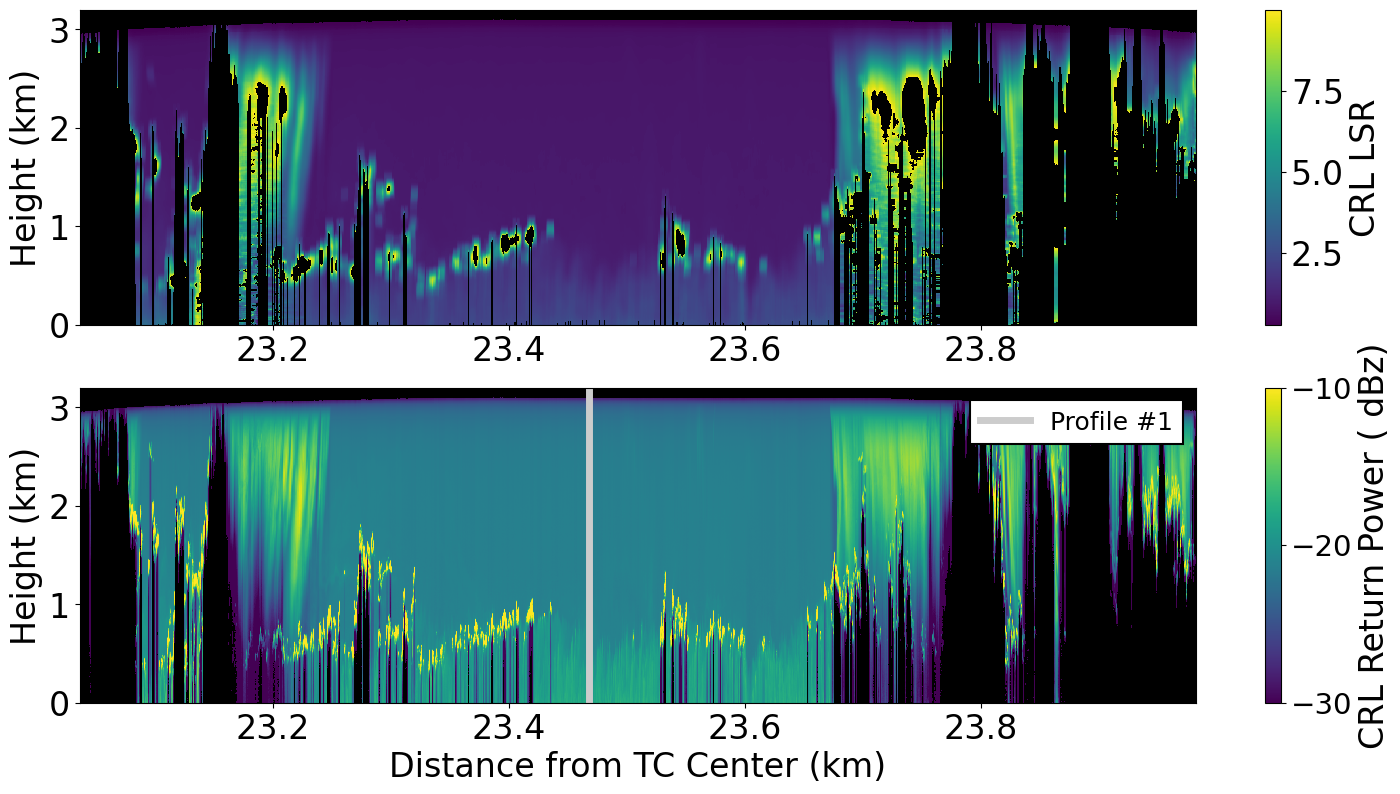

In [10]:
# make figure 3
fs = 24
newprofile = 775
ind0, ind1 = 3300, 5000

fig = plt.figure( figsize=(18, 9))
helper_fns.change_font_sizes(small=fs, medium=fs)

# plot crl data
xaxis = crl_data.time.values[ind0:ind1]
power = crl_data.P_ch1[ind0:ind1].values.transpose()
lsr = crl_data.LSR[ind0:ind1].values.transpose()

# plot things
plt.subplot(211)
plt.pcolormesh(  xaxis, crl_data.height / 1000, lsr)
plt.ylabel( 'Height (km)')
cbar = plt.colorbar(label="CRL LSR")
# cbar.ax.set_ylabel( ylabel="CRL LSR")
# cbar.ax.tick_params(labelsize=21)
plt.ylim( [ 0, 3.2])
ax = plt.gca()
ax.set_facecolor('k')
warnings.filterwarnings("default")

plt.subplot(212)
plt.pcolormesh(  xaxis, crl_data.height / 1000, power, vmin = -30, vmax =-10)
plt.ylabel( 'Height (km)')    
cbar = plt.colorbar(label="CRL Return Power ( dBz)", ticks=[-30, -20, -10])
cbar.ax.set_ylabel( ylabel="CRL Return Power ( dBz)")
cbar.ax.tick_params(labelsize=21)
plt.ylim( [ 0, 3.2])
ax = plt.gca()
ax.set_facecolor('k')
warnings.filterwarnings("default")
plt.xlabel("Distance from TC Center (km)")

# plt.xlim([])

plt.axvline( x=xaxis[newprofile], c='.8', alpha = 1, linewidth=5, label="Profile #1")


# leg = plt.legend( loc='upper right', bbox_to_anchor=(1.01, 1.15), fancybox=False, shadow=False, fontsize=17, facecolor='w', framealpha=1) # 1.3
leg = plt.legend( loc='upper right', fancybox=False, shadow=False, fontsize=18, facecolor='w', framealpha=1) # 1.3
leg.get_frame().set_linewidth( 1.5) 
leg.get_frame().set_edgecolor('k')


Text(0.5, 0, 'Density (Kg/m^3)')

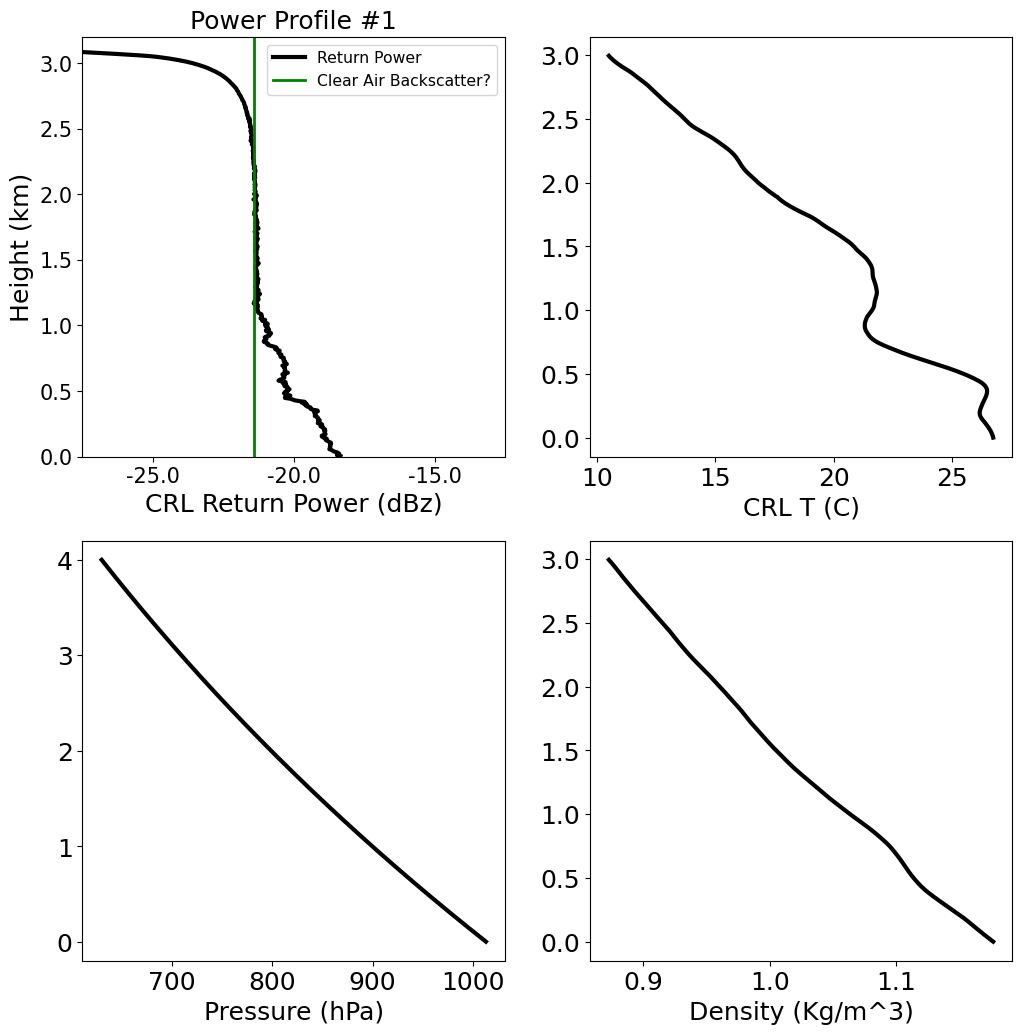

In [12]:
# correct power using a weighting function here!
power_orig = power[:, newprofile]

# also get temp, pressure, and density along this vertical profile
T = crl_data.T[ind0:ind1].transpose()[:, newprofile].values
p = find_p( crl_data.height.values)
rho = find_rho(p, T)

plt.figure( figsize=( 12, 12))
helper_fns.change_font_sizes(small=18, medium=18)
labelfont=15

plt.subplot(221)
plt.plot( power_orig, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.axvline(x=-21.4, c='g', linewidth=2, label='Clear Air Backscatter?')
plt.xticks( [-25.00, -20.0, -15.0])
ax= plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.tick_params(axis='both', which='major', labelsize=labelfont)
plt.legend(loc='upper right', fontsize=labelfont * .75)
plt.xlabel( "CRL Return Power (dBz)")
plt.ylabel( "Height (km)")
plt.title( "Power Profile #1")
plt.ylim( [ 0, 3.2])
plt.xlim( [-27.5, -12.5])


plt.subplot(222)
plt.plot( T, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.xlabel( "CRL T (C)")

plt.subplot(223)
plt.plot( p, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.xlabel( "Pressure (hPa)")

plt.subplot(224)
plt.plot( rho, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.xlabel( "Density (Kg/m^3)")


In [13]:
import os
os.chdir( "/Users/etmu9498/research/code/scripts-winter2023/crl-data-processing")
import save_crl_data

# save-crl-data.py
# give it a year (txt), 'all', or an input dictionary like: inputdict['2021'] = ['P3_20210818H1_211425-244159.cdf']

inputdict = {}
inputdict['2021'] = ["P3_20210816H1_085245-123459.cdf"] # 'P3_20210811H1_200000-224759.cdf'] # ["P3_20210926H1_220900-255058.cdf", "P3_20210927H1_213003-253558.cdf", "P3_20210929H2_211201-261159.cdf"]
# save_crl_data.save_tcs( tc=inputdict, add_dist_coords={'new_heights': True, 'fl_fields': True, 'rmw': True})


-0.524812494562676
-39.98430558730561
-22.969805618198258
(1272, 4000)
[  9   9   9 ... 883 883 883]
2306510


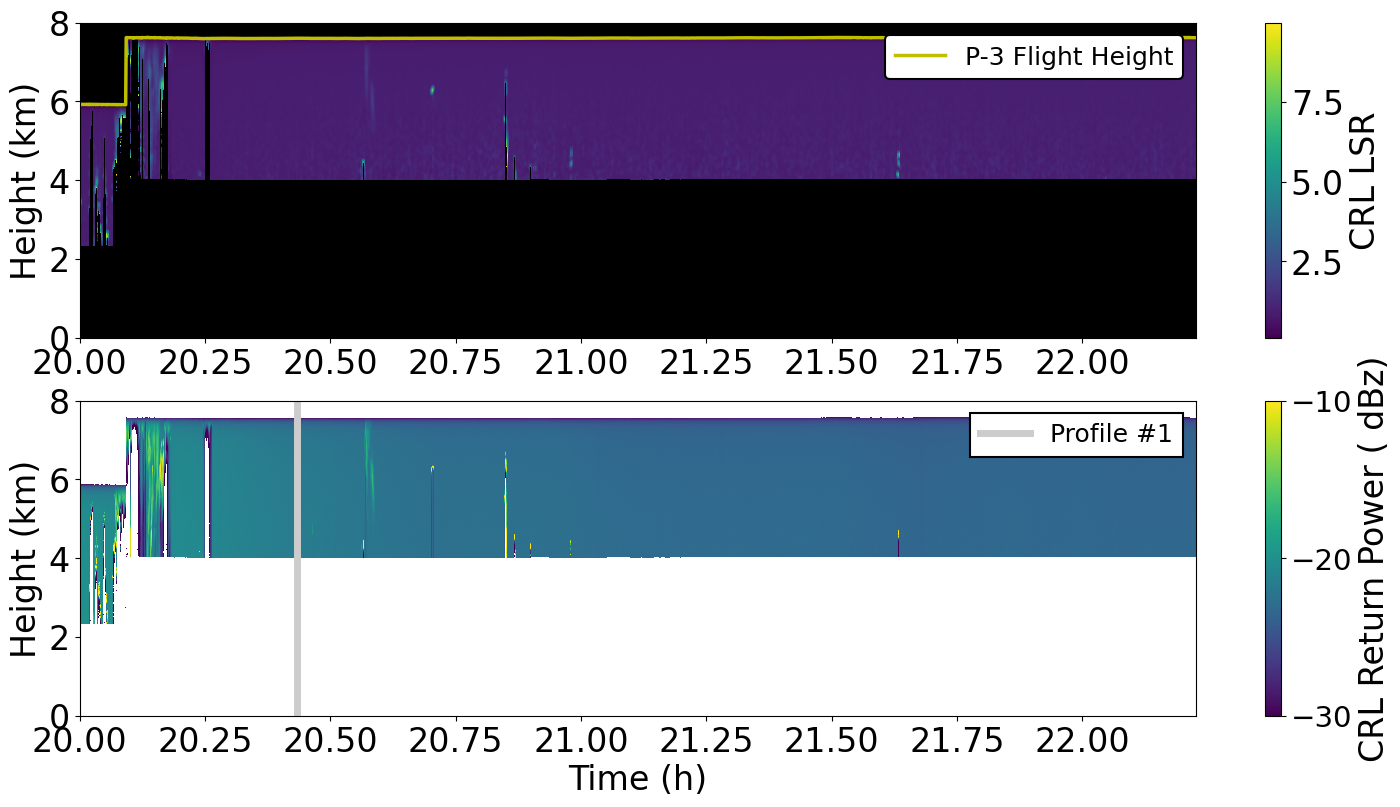

(array([  0.99700506, -21.4635397 ,   0.95068825,   7.03855548]), array([[ 8.43789510e+08, -1.81651129e+10, -3.14677024e+01,
        -8.90222615e+08],
       [-1.81651129e+10,  3.91058816e+11,  6.77436801e+02,
         1.91647255e+10],
       [-3.14677320e+01,  6.77437439e+02,  1.98717802e-03,
         3.31983266e+01],
       [-8.90222615e+08,  1.91647255e+10,  3.31982953e+01,
         9.39210900e+08]]))
[-70.  -69.9 -69.8 -69.7 -69.6 -69.5 -69.4 -69.3 -69.2 -69.1 -69.  -68.9
 -68.8 -68.7 -68.6 -68.5 -68.4 -68.3 -68.2 -68.1 -68.  -67.9 -67.8 -67.7
 -67.6 -67.5 -67.4 -67.3 -67.2 -67.1 -67.  -66.9 -66.8 -66.7 -66.6 -66.5
 -66.4 -66.3 -66.2 -66.1 -66.  -65.9 -65.8 -65.7 -65.6 -65.5 -65.4 -65.3
 -65.2 -65.1 -65.  -64.9 -64.8 -64.7 -64.6 -64.5 -64.4 -64.3 -64.2 -64.1
 -64.  -63.9 -63.8 -63.7 -63.6 -63.5 -63.4 -63.3 -63.2 -63.1 -63.  -62.9
 -62.8 -62.7 -62.6 -62.5 -62.4 -62.3 -62.2 -62.1 -62.  -61.9 -61.8 -61.7
 -61.6 -61.5 -61.4 -61.3 -61.2 -61.1 -61.  -60.9 -60.8 -60.7 -60.6 -60.5
 -60.4 -

C:\Users\etmu9498\AppData\Local\Temp\ipykernel_10412\1008146409.py:102: RuntimeWarning: invalid value encountered in log
  return np.log( - a * powertemp + b) / c + d


(3.0, 8.0)

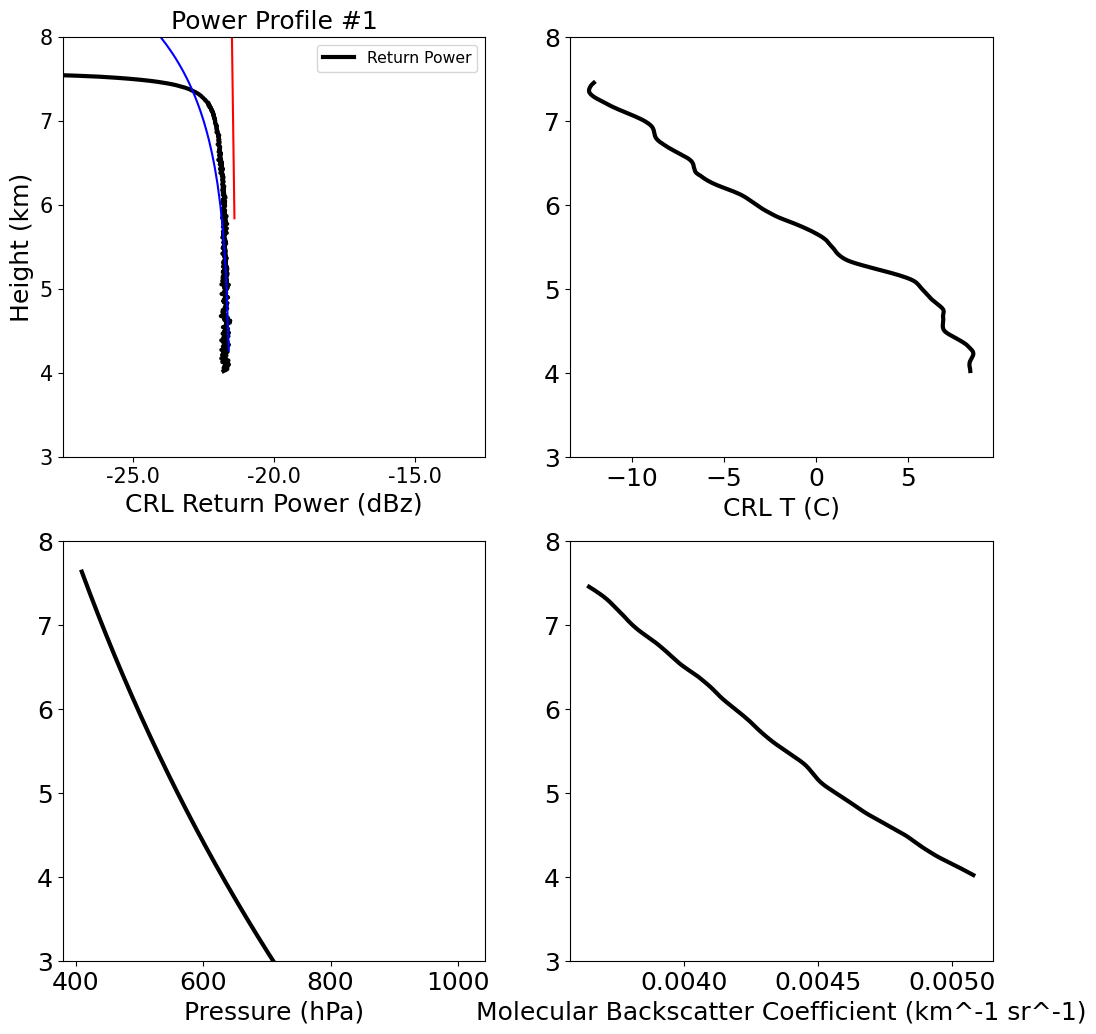

In [39]:
# Repeat plots 3 and 4 with another case

# load data and helpful values
crl_path = "/Users/etmu9498/research/data/crl-all-data-processed/2021/"
crl_name = "P3_20210811H1_processed.nc" # "P3_20210927H1_processed.nc"
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)

# make figure 3
fs = 24
newprofile = 780
ind0, ind1 = 0, 4000

fig = plt.figure( figsize=(18, 9))
helper_fns.change_font_sizes(small=fs, medium=fs)

# plot crl data
xaxis = crl_data.time.values[ind0:ind1]
power = crl_data.P_ch1[ind0:ind1].values.transpose()
lsr = crl_data.LSR[ind0:ind1].values.transpose()

print(np.nanmax(power))
print(np.nanmin(power))
print(np.nanmean(power))
print(np.shape(power))
print(np.where(~np.isnan(power))[0])
print(len(np.where(~np.isnan(power))[0]))

# plot things
plt.subplot(211)
plt.pcolormesh(  xaxis, crl_data.height / 1000, lsr)
plt.ylabel( 'Height (km)')
cbar = plt.colorbar(label="CRL LSR")
# cbar.ax.set_ylabel( ylabel="CRL LSR")
# cbar.ax.tick_params(labelsize=21)

plt.ylim( [ 0, 8])

plt.plot(xaxis, crl_data.p3_height[ind0:ind1] / 1000., linewidth=2.5, c='y', label="P-3 Flight Height")

leg = plt.legend( loc='upper right', shadow=False, fontsize=18, facecolor='w', framealpha=1)
leg.get_frame().set_linewidth( 1.5) 
leg.get_frame().set_edgecolor('k')

ax = plt.gca()
ax.set_facecolor('k')
warnings.filterwarnings("default")

plt.subplot(212)
plt.pcolormesh(  xaxis, crl_data.height / 1000, power, vmin = -30, vmax =-10)
plt.ylabel( 'Height (km)')    
cbar = plt.colorbar(label="CRL Return Power ( dBz)", ticks=[-30, -20, -10])
cbar.ax.set_ylabel( ylabel="CRL Return Power ( dBz)")
cbar.ax.tick_params(labelsize=21)

plt.ylim( [ 0, 8])

ax = plt.gca()
# ax.set_facecolor('k')
warnings.filterwarnings("default")
plt.xlabel("Time (h)")

plt.axvline( x=xaxis[newprofile], c='.8', alpha = 1, linewidth=5, label="Profile #1")

# leg = plt.legend( loc='upper right', bbox_to_anchor=(1.01, 1.15), fancybox=False, shadow=False, fontsize=17, facecolor='w', framealpha=1) # 1.3
leg = plt.legend( loc='upper right', fancybox=False, shadow=False, fontsize=18, facecolor='w', framealpha=1) # 1.3
leg.get_frame().set_linewidth( 1.5) 
leg.get_frame().set_edgecolor('k')

plt.show()

# correct power using a weighting function here!
power_orig = power[:, newprofile]
# also get temp, pressure, and density along this vertical profile
T = crl_data.T[ind0:ind1].transpose()[:, newprofile].values
p = find_p( crl_data.height.values)
rho = find_rho(p, T)

mbc = find_molec_backscatter(p, T, crl_wavelength = 355.0)

plt.figure( figsize=( 12, 12))
helper_fns.change_font_sizes(small=18, medium=18)
labelfont=15

plt.subplot(221)
plt.plot( power_orig, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.xticks( [-25.00, -20.0, -15.0])
ax= plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.tick_params(axis='both', which='major', labelsize=labelfont)
plt.legend(loc='upper right', fontsize=labelfont * .75)
plt.xlabel( "CRL Return Power (dBz)")
plt.ylabel( "Height (km)")
plt.title( "Power Profile #1")

plt.xlim( [-27.5, -12.5])
plt.ylim([3,8])
# plt.xlim([-70, 0])
# plt.ylim([-20,40])

def neglog( powertemp, a, b, c, d):
    return np.log( - a * powertemp + b) / c + d

power_inds = np.where( ~ np.isnan( power_orig))[0]
power_nonans = power_orig[ power_inds]
h_nonans = crl_data.height[power_inds].values / 1000

t0 = (1., -21.4, 10, 8.5) # initial guesses
opt_vals = opt.curve_fit(neglog, power_nonans, h_nonans, t0)
a, b, c, d = opt_vals[0][0], opt_vals[0][1], opt_vals[0][2], opt_vals[0][3]

xlinear = np.arange(-70,0, .1)
ylinear = neglog( xlinear, a, b, c, d)

print(opt_vals)
print(xlinear)
print(a)
print(b)
print(c)

plt.plot(xlinear, ylinear, c='b', label='best fit')
plt.plot(xlinear, neglog( xlinear, t0[0], t0[1], t0[2], t0[3]), c='r', label='manual fit')

plt.subplot(222)
plt.plot( T, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.xlabel( "CRL T (C)")
plt.ylim([3,8])

plt.subplot(223)
plt.plot( p, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.xlabel( "Pressure (hPa)")
plt.ylim([3,8])

plt.subplot(224)
plt.plot( mbc, crl_data.height/1000, c='k', linewidth=3, label="Return Power")
plt.xlabel( "Molecular Backscatter Coefficient (km^-1 sr^-1)")
plt.ylim([3,8])
